##Python Imports and Loading in Data

In [1]:
#Loading in necessary Python packages
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import random
import os

#Setting seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
#Importing kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eleanorbain","key":"4200ec89cdf28b78175a5f4057fd03a5"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle

In [5]:
#Downloading data from kaggle
!kaggle competitions download -c digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 797MB/s]


In [6]:
#Unzipping the data file
!unzip 'digit-recognizer.zip'

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
#Saving the training set to "train_df"
train_df = pd.read_csv("train.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Examining the shape
train_df.shape

(42000, 785)

In [9]:
#Saving the test set to "test_df"
test_df = pd.read_csv("test.csv")
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Examining the shape
test_df.shape

(28000, 784)

In [11]:
#Printing the current version of Keras that the model will use
print(keras.__version__)

3.10.0


In [12]:
#Checking if each class is balanced in the training set
train_df["label"].value_counts()

,count
label,
1,4684
7,4401
3,4351
9,4188
2,4177
6,4137
0,4132
4,4072
8,4063


# Preprocessing and splitting

In [13]:
#Splitting the Training dataframe into training and validation sets
#Normalizing and reshaping the image pixels to be easier to process

from sklearn.model_selection import train_test_split

#Extracting labels and image pixels
labels = train_df["label"].values
images = train_df.drop(columns=["label"]).values

# Train/validation split (80% / 20%)
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.20, random_state=42, shuffle=True
)

#Reshaping into (n, 28, 28, 1)
train_images = train_images.reshape((-1, 28, 28, 1))
val_images = val_images.reshape((-1, 28, 28, 1))

#Normalizing
train_images = train_images.astype("float32") / 255.0
val_images = val_images.astype("float32") / 255.0

#Testing set has no labels — only pixel columns
test_images = test_df.values

#Reshaping
test_images = test_images.reshape((-1, 28, 28, 1))

#Normalizing
test_images = test_images.astype("float32") / 255.0


# Convolutional Neural Network Model

In [14]:
#Augmenting the Data to improve model performance
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)
datagen.fit(train_images)

In [15]:
#Setting model hyperparameters
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
#Compiling the model
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

#Fitting the model
model.fit(datagen.flow(train_images, train_labels, batch_size=64),
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7361 - loss: 0.7838
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9599 - loss: 0.1272
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9746 - loss: 0.0839
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9793 - loss: 0.0684
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9837 - loss: 0.0534
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9861 - loss: 0.0476
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9871 - loss: 0.0415
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9882 - loss: 0.0382
Epoch 9/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9875 - loss: 0.0389
Epoch 10/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9883 - loss: 0.0376


In [17]:
#Measuring model performance using validation set
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(f"Test accuracy: {val_acc:.4f}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9922 - loss: 0.0241
Test accuracy: 0.9942


# Further metric testing on Validation set

In [21]:
#Calculating and Printing validation AUC
from sklearn.metrics import roc_auc_score
val_pred = model.predict(val_images)
macro_auc = roc_auc_score(val_labels, val_pred, multi_class='ovr', average='macro')
micro_auc = roc_auc_score(val_labels, val_pred, multi_class='ovr', average='micro')
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Macro AUC: 1.0000
Micro AUC: 1.0000


In [19]:
#More validation AUC
from sklearn.metrics import roc_auc_score
import numpy as np

num_classes = val_pred.shape[1]
per_class_auc = {}

for c in range(num_classes):
    y_true_binary = (val_labels == c).astype(int)
    auc = roc_auc_score(y_true_binary, val_pred[:, c])
    per_class_auc[c] = auc

print("Per-class AUC:")
for c, a in per_class_auc.items():
    print(f"Class {c}: {a:.4f}")


Per-class AUC:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000


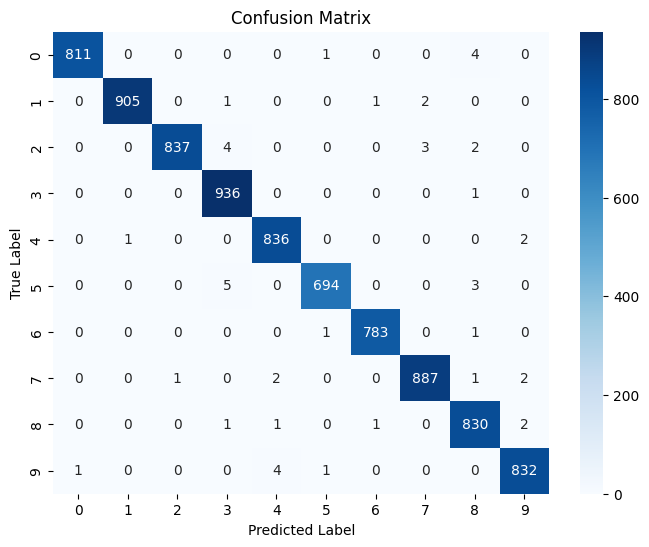

In [45]:
#Creating a confusion matrix of predicted vs. true classes
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.argmax(val_pred, axis=1)
cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [47]:
#Checking to see what the "y_pred" array looks like
y_pred

array([8, 1, 9, ..., 3, 0, 9])

In [48]:
#And the true labels too
val_labels

array([8, 1, 9, ..., 3, 0, 9])

In [49]:
#Saving both arrays to a dataframe
df = pd.DataFrame({
    'index': range(len(y_pred)),
    'y_pred': y_pred,
    'val_labels': val_labels
})
df.head()

,index,y_pred,val_labels
0,0,8,8
1,1,1,1
2,2,9,9
3,3,9,9
4,4,8,8


In [50]:
#Printing the number of misclassified rows and the indexes at which they occur
misclassified_rows = []
for index, row in df.iterrows():
    if row['y_pred'] != row['val_labels']:
        misclassified_rows.append(int(row['index']))

print(f"Number of misclassified rows: {len(misclassified_rows)}")
print(f"Indices of misclassified rows: {misclassified_rows}")

Number of misclassified rows: 49
Indices of misclassified rows: [65, 139, 316, 445, 641, 666, 841, 881, 976, 1182, 1220, 1558, 1870, 1943, 1991, 2199, 2311, 2393, 2638, 3002, 3073, 3171, 3187, 3451, 3932, 3981, 4003, 4187, 4293, 4521, 4564, 4622, 4731, 5091, 5158, 5161, 5609, 6071, 6118, 6277, 6305, 6590, 7107, 7264, 7595, 7641, 7802, 8008, 8387]


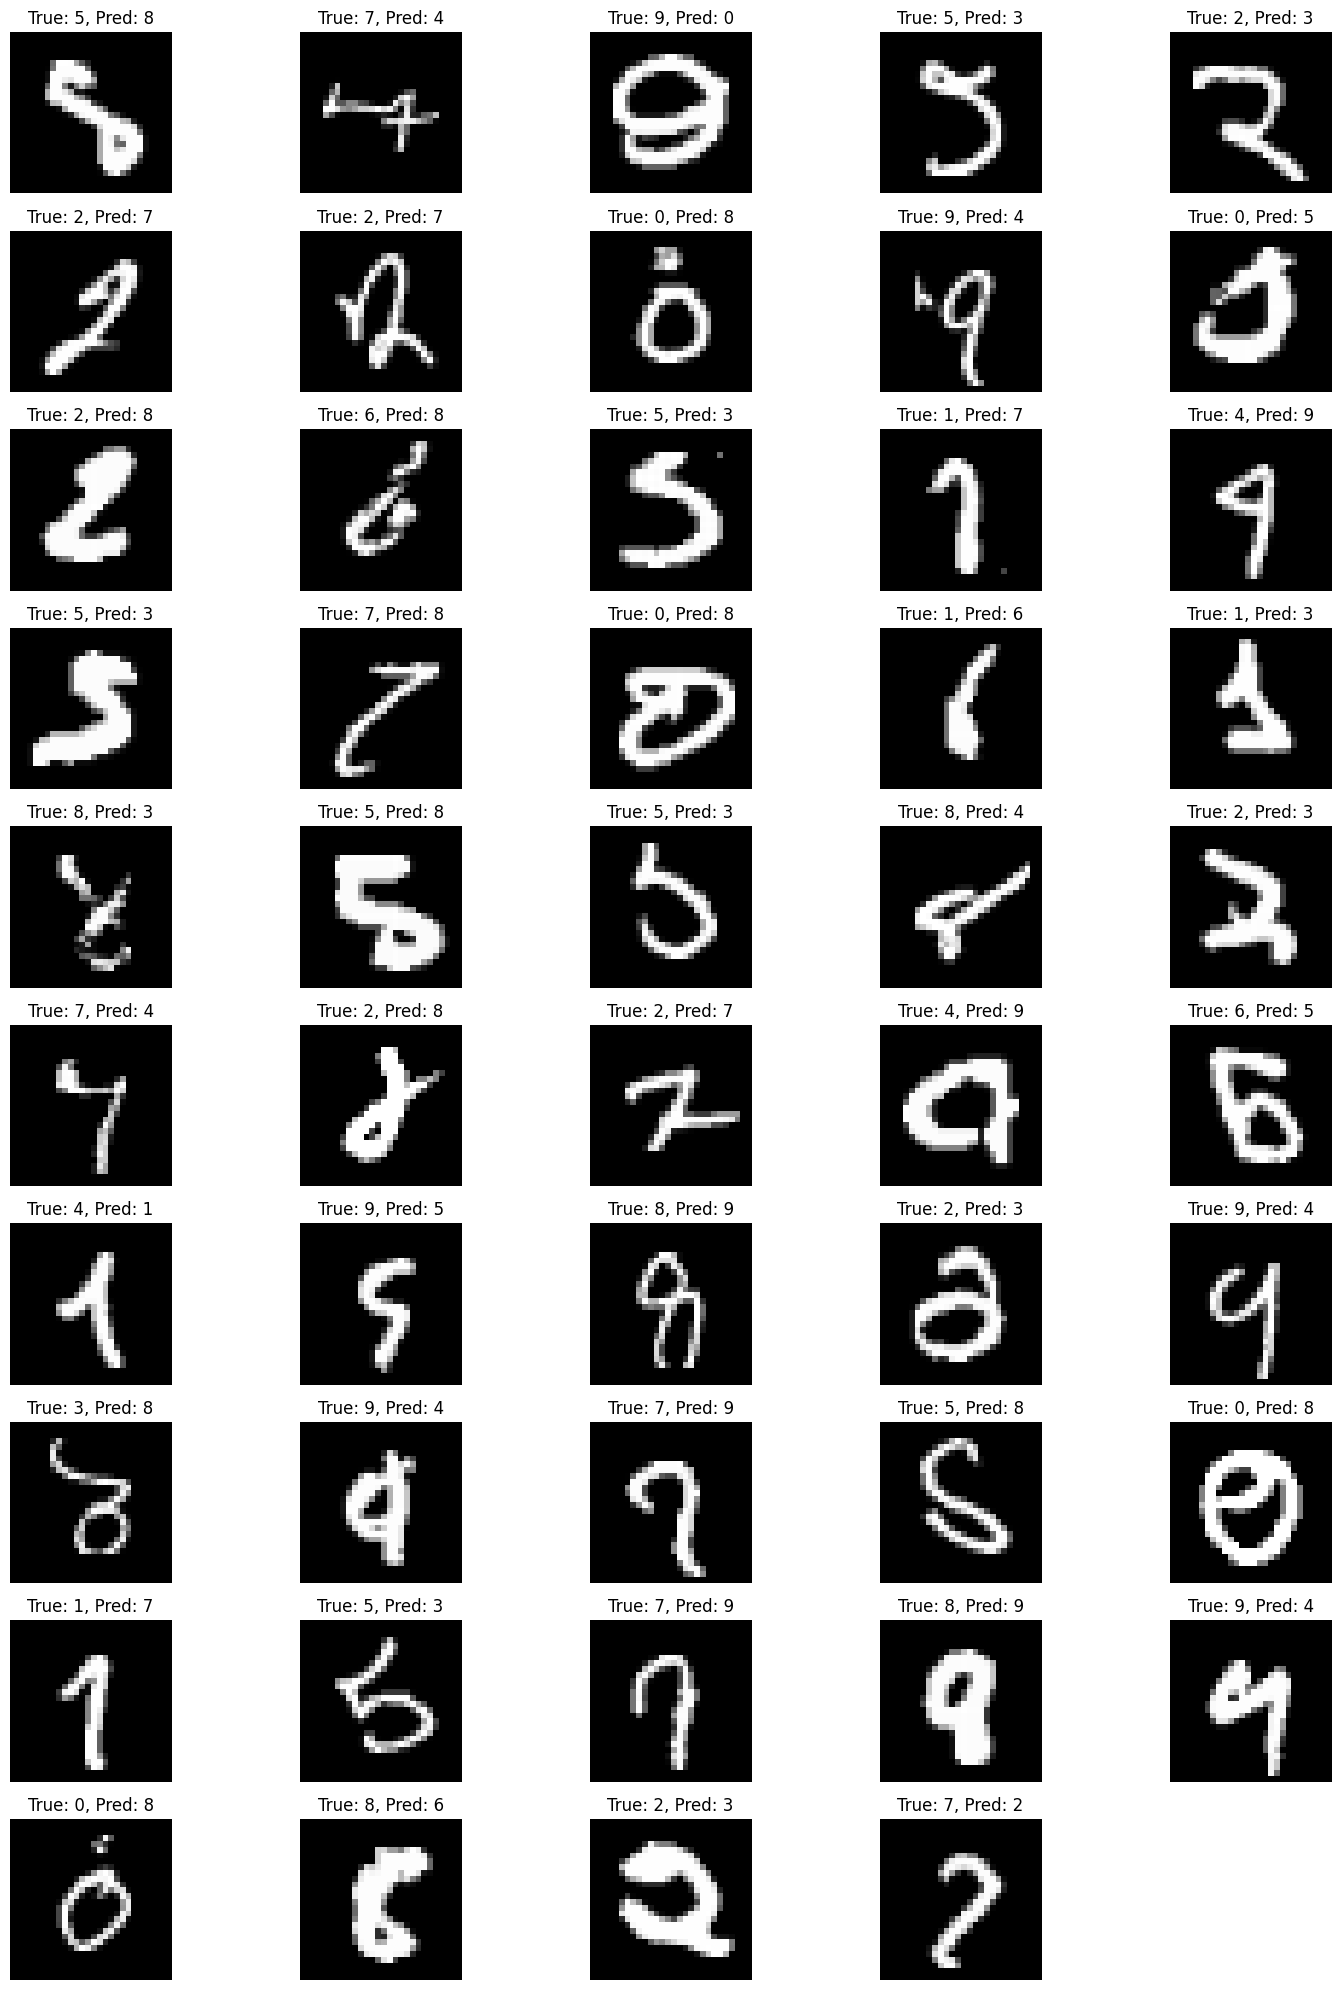

In [53]:
#Printing the images of the digits that were misclassified
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
for i, idx in enumerate(misclassified_rows):
    plt.subplot(10, 5, i + 1)
    plt.imshow(val_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {val_labels[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Making predictions for the unseen test data

In [55]:
#Printing the test dataframe
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#Predicting values on the test data using the trained model
test_pred_probs = model.predict(test_images)

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [62]:
test_pred_probs

array([[5.5308601e-13, 2.1649837e-12, 9.9999988e-01, ..., 6.1029196e-11,
        1.9758419e-10, 4.1273097e-14],
       [9.9999881e-01, 1.7276148e-12, 1.3731903e-07, ..., 1.6528104e-10,
        3.4871569e-08, 6.0744235e-08],
       [7.0633249e-11, 7.4468406e-14, 5.2203607e-08, ..., 1.8351036e-08,
        1.8181776e-05, 9.9997687e-01],
       ...,
       [5.6731972e-21, 8.6989238e-17, 4.0928913e-16, ..., 1.8227139e-15,
        1.4904782e-12, 7.5418382e-15],
       [1.2133512e-10, 3.6316985e-12, 8.5541429e-10, ..., 8.9681116e-08,
        3.7311758e-09, 9.9999177e-01],
       [1.9557680e-17, 1.6868845e-17, 1.0000000e+00, ..., 2.7231196e-14,
        2.0090615e-12, 6.2463622e-18]], dtype=float32)

In [63]:
#Making probabilities into the real predictions
test_preds = np.argmax(test_pred_probs, axis=1)

In [67]:
test_preds

array([2, 0, 9, ..., 3, 9, 2])

In [64]:
#Building the submission DataFrame
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(test_preds) + 1),
    "Label": test_preds
})

In [66]:
#Saving to CSV to submit to Kaggle for evaluation
submission.to_csv("submission.csv", index=False)